# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 2.1

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter2_1()
# This is needed to render the plots in this chapter
from plots.chapter2_1 import *

In [2]:
import numpy as np
import datetime

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Going Classy

## The Class

In [5]:
# A completely empty (and useless) class
class StepByStep(object):
    pass

## The Constructor

### Arguments

In [6]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

### Placeholders

In [7]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
        # These attributes are defined here, but since they are
        # not available at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader 
        # (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to create a SummaryWriter to 
        # interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

### Variables

In [8]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
        # These attributes are defined here, but since they are
        # not available at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader 
        # (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to create a SummaryWriter to 
        # interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

### Functions

In [9]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
        # These attributes are defined here, but since they are
        # not available at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step = self._make_train_step()
        # Creates the val_step function for our model and loss
        self.val_step = self._make_val_step()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader 
        # (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to create a SummaryWriter to 
        # interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

### Step Methods

In [10]:
def _make_train_step_fn(self):
    # This method does not need ARGS... it can refer to
    # the attributes: self.model, self.loss_fn and self.optimizer

    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        self.model.train()

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = self.model(x)
        # Step 2 - Computes the loss
        loss = self.loss_fn(yhat, y)
        # Step 3 - Computes gradients for both "b" and "w" parameters
        loss.backward()
        # Step 4 - Updates parameters using gradients and the
        # learning rate
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

def _make_val_step_fn(self):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        self.model.eval()

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = self.model(x)
        # Step 2 - Computes the loss
        loss = self.loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, 
        # since we don't update parameters during evaluation
        return loss.item()

    return perform_val_step_fn

In [ ]:
# ATTENTION! Using SETATTR for educational purposes only :-)
setattr(StepByStep, '_make_train_step_fn', _make_train_step_fn)
setattr(StepByStep, '_make_val_step_fn', _make_val_step_fn)

### setattr

In [11]:
class Dog(object):
    def __init__(self, name):
        self.name = name

In [12]:
rex = Dog('Rex')
print(rex.name)

Rex


In [13]:
def bark(dog):
    print('{} barks: "Woof!"'.format(dog.name))

In [14]:
bark(rex)

Rex barks: "Woof!"


In [15]:
def bark(self):
    print('{} barks: "Woof!"'.format(self.name))

setattr(Dog, 'bark', bark)

In [16]:
fido = Dog('Fido')
fido.bark()

Fido barks: "Woof!"


In [17]:
rex.bark()

Rex barks: "Woof!"


## Training Methods

### Mini-Batch

In [18]:
def _mini_batch(self, validation=False):
    # The mini-batch can be used with both loaders
    # The argument `validation`defines which loader and 
    # corresponding step function is going to be used
    if validation:
        data_loader = self.val_loader
        step_fn = self.val_step_fn
    else:
        data_loader = self.train_loader
        step_fn = self.train_step_fn

    if data_loader is None:
        return None

    # Once the data loader and step function, this is the same
    # mini-batch loop we had before
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)

    return loss

setattr(StepByStep, '_mini_batch', _mini_batch)

### Training Loop

In [1]:
def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
setattr(StepByStep, 'set_seed', set_seed)

In [19]:
def train(self, n_epochs, seed=42):
    # To ensure reproducibility of the training process
    self.set_seed(seed)
    
    for epoch in range(n_epochs):
        # Keeps track of the numbers of epochs
        # by updating the corresponding attribute
        self.total_epochs += 1

        # inner loop
        # Performs training using mini-batches
        loss = self._mini_batch(validation=False)
        self.losses.append(loss)

        # VALIDATION
        # no gradients in validation!
        with torch.no_grad():
            # Performs evaluation using mini-batches
            val_loss = self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        # If a SummaryWriter has been set...
        if self.writer:
            scalars = {'training': loss}
            if val_loss is not None:
                scalars.update({'validation': val_loss})
            # Records both losses for each epoch under the main tag "loss"
            self.writer.add_scalars(main_tag='loss',
                                    tag_scalar_dict=scalars,
                                    global_step=epoch)

    if self.writer:
        # Flushes the writer
        self.writer.flush()
        
setattr(StepByStep, 'train', train)

## Saving and Loading Methods

### Saving

In [20]:
def save_checkpoint(self, filename):
    # Builds dictionary with all elements for resuming training
    checkpoint = {'epoch': self.total_epochs,
                  'model_state_dict': self.model.state_dict(),
                  'optimizer_state_dict': self.optimizer.state_dict(),
                  'loss': self.losses,
                  'val_loss': self.val_losses}

    torch.save(checkpoint, filename)
    
setattr(StepByStep, 'save_checkpoint', save_checkpoint)

### Loading

In [21]:
def load_checkpoint(self, filename):
    # Loads dictionary
    checkpoint = torch.load(filename)

    # Restore state for model and optimizer
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    self.total_epochs = checkpoint['epoch']
    self.losses = checkpoint['loss']
    self.val_losses = checkpoint['val_loss']

    self.model.train() # always use TRAIN for resuming training   
    
setattr(StepByStep, 'load_checkpoint', load_checkpoint)

### Making Predictions

In [22]:
def predict(self, x):
    # Set is to evaluation mode for predictions
    self.model.eval() 
    # Takes aNumpy input and make it a float tensor
    x_tensor = torch.as_tensor(x).float()
    # Send input to device and uses model for prediction
    y_hat_tensor = self.model(x_tensor.to(self.device))
    # Set it back to train mode
    self.model.train()
    # Detaches it, brings it to CPU and back to Numpy
    return y_hat_tensor.detach().cpu().numpy()

setattr(StepByStep, 'predict', predict)

## Visualization Methods

### Losses

In [23]:
def plot_losses(self):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(self.losses, label='Training Loss', c='b')
    if self.val_loader:
        plt.plot(self.val_losses, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

setattr(StepByStep, 'plot_losses', plot_losses)

### Model Graph

In [24]:
def add_graph(self):
    if self.train_loader and self.writer:
        # Fetches a single mini-batch so we can use add_graph
        x_sample, y_sample = next(iter(self.train_loader))
        self.writer.add_graph(self.model, x_sample.to(self.device))
    
setattr(StepByStep, 'add_graph', add_graph)

## The Full Code

In [13]:
# %load stepbystep/v0.py

import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

plt.style.use('fivethirtyeight')

class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn
    
    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, 
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the 
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))


## Classy Pipeline

### Data Generation

In [14]:
# Runs data generation - so we do not need to copy code here
%run -i data_generation/simple_linear_regression.py

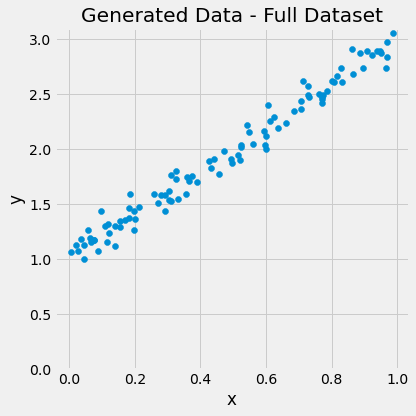

In [15]:
fig = figure1(x, y)

### Data Preparation V2

In [16]:
# %load data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

### Model Configuration V4

In [17]:
%%writefile model_configuration/v4.py

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

Overwriting model_configuration/v4.py


In [18]:
%run -i model_configuration/v4.py

<Figure size 432x288 with 0 Axes>

In [19]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


## Model Training

### Cell 2.1.1

In [20]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')

In [44]:
print(sbs.model == model)
print(sbs.model)

True
Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


### Cell 2.1.2

In [45]:
sbs.train(n_epochs=200)

In [46]:
print(model.state_dict()) # remember, model == sbs.model
print(sbs.total_epochs)

OrderedDict([('0.weight', tensor([[1.9414]], device='cuda:0')), ('0.bias', tensor([1.0233], device='cuda:0'))])
200


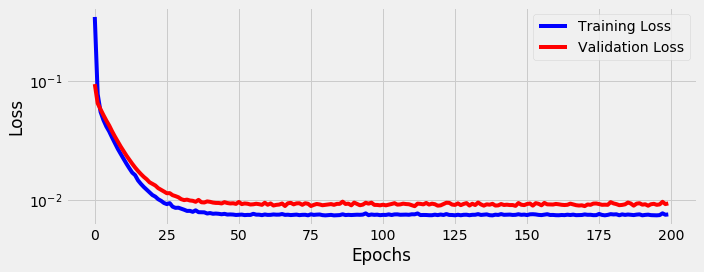

In [47]:
fig = sbs.plot_losses()

### Making Predictions

In [48]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)
new_data

array([[0.5],
       [0.3],
       [0.7]])

In [49]:
predictions = sbs.predict(new_data)
predictions

array([[1.9939734],
       [1.6056864],
       [2.3822603]], dtype=float32)

### Checkpointing

### Cell 2.1.3

In [50]:
sbs.save_checkpoint('model_checkpoint.pth')

### Resuming Training

In [51]:
%run -i model_configuration/v4.py

In [52]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')), ('0.bias', tensor([0.8300], device='cuda:0'))])


### Cell 2.1.4

In [ ]:
new_sbs = StepByStep(model, loss_fn, optimizer)

### Cell 2.1.5

In [53]:
new_sbs.load_checkpoint('model_checkpoint.pth')
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9414]], device='cuda:0')), ('0.bias', tensor([1.0233], device='cuda:0'))])


### Cell 2.1.6

In [54]:
new_sbs.set_loaders(train_loader, val_loader)
new_sbs.train(n_epochs=50)

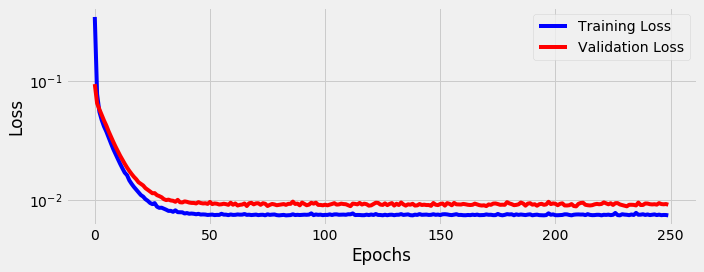

In [55]:
fig = new_sbs.plot_losses()

In [56]:
print(sbs.model.state_dict())

OrderedDict([('0.weight', tensor([[1.9414]], device='cuda:0')), ('0.bias', tensor([1.0233], device='cuda:0'))])


# Putting It All Together

In [57]:
# %load data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_data,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [58]:
# %load model_configuration/v4.py

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters 
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

In [59]:
n_epochs = 200

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')
sbs.train(n_epochs=n_epochs)

In [60]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9414]], device='cuda:0')), ('0.bias', tensor([1.0233], device='cuda:0'))])
